# Redes MLP

Melhores resultados: 

|      | MLP |
|------|------------------|
| RMSE | 35724.18         |
| MAE  | 23680.35         |
| MAPE | 0.30             |

Config:

4 camadas com ativação relu e units (256, 128, 64, 32) e minmax

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Paired")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

# Constantes e funções

In [2]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

N='NORTE'
NE="NORDESTE"
CO='CENTRO OESTE'
SE='SUDESTE'
S = 'SUL'

REGIOES = {
    'AC': N, 'AL': NE, 'AM' : N, 'AP' : N, 'BA' : NE, 'CE' : NE,
    'DF' : CO, 'ES' : SE, 'GO' : CO, 'MA' : NE,
    'MG' : SE, 'MS' : CO, 'MT' : CO, 'PA' : N, 'PB' : NE,
    'PE' : NE, 'PI' : NE, 'PR' : S, 'RJ' : SE,
    'RN' : NE, 'RO' : N, 'RR' : N, 'RS' : S,
    'SC' : S, 'SE' : NE, 'SP' : SE, 'TO' : N}

In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [4]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [5]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    
    plt.show()

In [6]:
def get_regiao (x):
    return REGIOES[x]

In [7]:
def get_pred (y_test, y_pred):
    
    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date
    
    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    pred['estados'] = SIGLAS * 30
    
    pred['y_test'] =  y_test[len(y_test) % 27 :].values
    pred['y_pred'] = y_pred[len(y_pred) % 27 :]
    
    pred = pred.set_index('data')
    
    pred['regiao'] = pred['estados'].apply(get_regiao)
    
    return pred

In [8]:
def show_pred (pred, states=SIGLAS):
    
    for state in states:
        
        fig, ax = plt.subplots()

        pred[pred['estados'] == state].plot(y="y_pred", ax=ax, figsize=(12,6), color="coral", title=f"Previsão x Dado Real: {state}", ylabel="Consumo")
        pred[pred['estados'] == state].plot(y="y_test", linestyle=' ', marker="o", ax=ax)

    plt.show()

In [9]:
def show_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
    
    
    plt.title("Visão regional")
    
    for state in reg:
        
        sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
        sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.ylabel="Consumo"
        
    plt.show()

In [10]:
def region_metrics (pred):

    for reg in pred['regiao'].unique():
        
        print (f"Metricas de {reg}:")
        print (f"RMSE: {mean_squared_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'], squared=False)}")
        print (f"MAPE: {mean_absolute_percentage_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print (f"MAE: {mean_absolute_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print ("-------------------------------\n")

In [11]:
def region_graphs (pred, reg):
    
    plt.figure(figsize=(18,6))
        
    plt.title(f"Visão regional: {reg}")
    
    pred=pred[pred['regiao'] == reg]
    
    plt.ylabel="Consumo"
    sns.scatterplot(pred, x=pred.index, y='y_test', hue="estados")
    sns.lineplot(pred, x=pred.index, y='y_pred', hue="estados")
    
        
    plt.show()

In [12]:
def split_train_test_validation (x, y):
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, shuffle=False)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

# SEED

In [13]:
SEED = 41

def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

In [14]:
set_seeds(SEED)

# Dados

In [15]:
def load_data():
    
    df = pd.read_csv(f"{PATH}df.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

# Experimentos

## 1 camada de 16 neurônios

In [40]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

In [41]:
show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 246994.5583123613
MAE: 147465.818026902
MAPE: 0.9471601454914635
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 205140.496369055
MAE: 128625.65212503685
MAPE: 0.8810699978948591


In [42]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 856us/step
Scores obtidos:
RMSE: 252380.9841974362
MAE: 139685.8936822227
MAPE: 0.7674769773737242
26/26 [==============================] - 0s 828us/step
Scores obtidos:
RMSE: 215460.1433149431
MAE: 125583.7221095167
MAPE: 0.6903443206639711


In [43]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 244880.002863555
MAE: 143781.58958289263
MAPE: 0.9247737802702862
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 202006.66065521978
MAE: 122516.69067851578
MAPE: 0.8254966503337974


## 1 camada de 32 neurônios

In [44]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 222615.4069319665
MAE: 132372.31212510448
MAPE: 0.8835080330404502
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 172525.4785102701
MAE: 105886.70547431614
MAPE: 0.7553593188254287


## 2 camadas (64, 32)

In [45]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 42980.66356454916
MAE: 27333.241495545593
MAPE: 0.3407930040239255
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 72487.30166251094
MAE: 41688.525056887425
MAPE: 0.45167364299624935


In [46]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 40162.89346886373
MAE: 22041.020183820732
MAPE: 0.24241869277018482
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 85067.46176137406
MAE: 51262.53933291452
MAPE: 0.6114452652229234


## 3 camadas (128, 64, 32)

### StandardScaler

In [47]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 27556.72143577098
MAE: 15301.513673487007
MAPE: 0.16673003706652936
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 42846.9119162811
MAE: 29135.26887824025
MAPE: 0.47770256168767555


### MinMax Scaler

In [48]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 32945.09846272092
MAE: 18110.535597395887
MAPE: 0.193652099595709
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 70250.3876787842
MAE: 40208.55218528
MAPE: 0.4135292652352228


## 3 camadas (256, 128, 64)

### Standard Scaler

In [49]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 25710.126755412937
MAE: 14052.761911379823
MAPE: 0.1419378321674316
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 41052.36181872741
MAE: 28596.188618264434
MAPE: 0.4724360427798693


### MinMax Scaler

#### 100 epochs

In [50]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 28786.171927940173
MAE: 16275.791318017235
MAPE: 0.1644445209469127
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 54061.29698054066
MAE: 32360.922779530683
MAPE: 0.36387714192783144


#### 200 epochs

In [51]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 25212.056703570743
MAE: 13813.622507921402
MAPE: 0.1283809989035499
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 38073.39585503491
MAE: 23786.566499537108
MAPE: 0.28657925699707326


#### 300 epochs

In [52]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 23594.56145472424
MAE: 12387.73334371829
MAPE: 0.11879556630046446
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 36879.70361745536
MAE: 23630.613575281513
MAPE: 0.30401697576411907


#### 400 epochs

In [53]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=400, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 22906.03620813578
MAE: 11777.318066761509
MAPE: 0.11208792438912324
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 37096.4164663876
MAE: 22433.28685194982
MAPE: 0.2875422268625101


## 4 camadas (256, 128, 64, 32)

### Standard Scaler

#### 100 epochs

In [54]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 29238.335655831394
MAE: 14845.843110212045
MAPE: 0.1336709434255861
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 40732.16826853963
MAE: 27382.68724493652
MAPE: 0.4169016138866787


### MinMax Scaler

#### 100 epochs

In [55]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 28274.753749089738
MAE: 16468.92998329517
MAPE: 0.17263123080814383
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 47574.7322185189
MAE: 29959.20036889737
MAPE: 0.36694508461906217


#### 200 epochs

In [56]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 24290.824202003176
MAE: 13374.97059621133
MAPE: 0.11639207651529683
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 37123.75087182423
MAE: 22941.216128514207
MAPE: 0.2712361135946469


In [57]:
x,y = load_data()

DROP=['pib_pc',  'selic', 'idh_e', 'idh_l', 'nfsp', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 31154.948640586907
MAE: 17595.223057034924
MAPE: 0.15669895029263015
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 53584.758555060005
MAE: 31680.736923273125
MAPE: 0.3242595818227049


#### 300 epochs

In [58]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 22717.430384511496
MAE: 12087.647796736474
MAPE: 0.11325686905588497
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 39154.12984932522
MAE: 26315.43974243312
MAPE: 0.3721434375636944


In [59]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=512, activation="relu")),
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 31895.475768694057
MAE: 17353.213675927702
MAPE: 0.1590916553555021
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 44641.59929921478
MAE: 28263.079956497506
MAPE: 0.3647782303833496


In [60]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=512, activation="relu")),
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 21103.092038744242
MAE: 10875.062087090348
MAPE: 0.09778049479074583
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 44156.99389831934
MAE: 26690.103548688785
MAPE: 0.3145519969418859


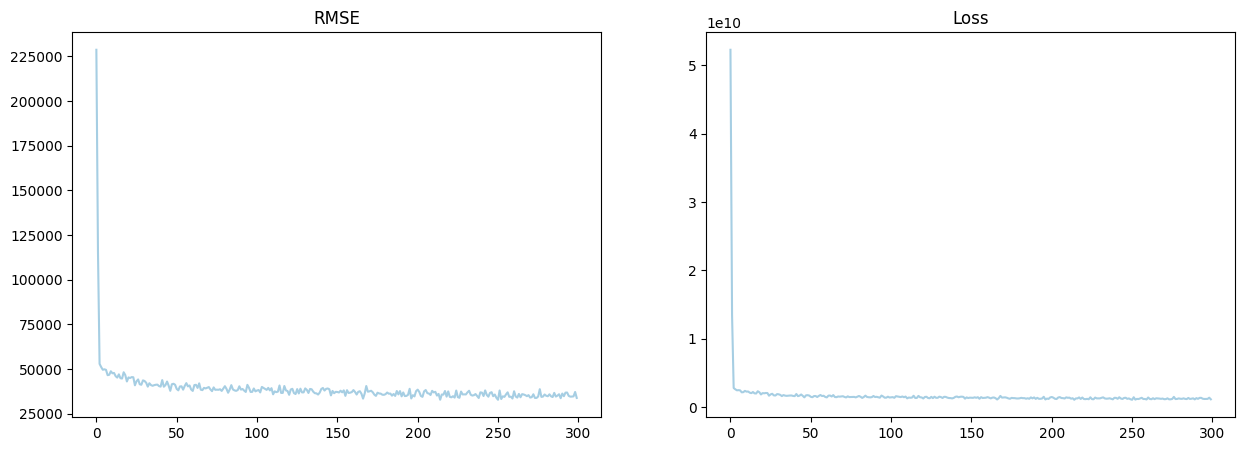

In [61]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [62]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="swish")),
model.add(Dense(units=16, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 39068.09279179905
MAE: 22350.865339306652
MAPE: 0.25089521737792153
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 65321.58401876516
MAE: 38329.77140407723
MAPE: 0.5299839695122729


### Swish

In [63]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=64, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 35343.44091652307
MAE: 21094.5707642332
MAPE: 0.26337986366234584
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 58396.53243278403
MAE: 35225.56994997922
MAPE: 0.5129997606690748


In [64]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="swish")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 30173.967544203802
MAE: 17517.654860789877
MAPE: 0.2050044578621235
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 57365.723975136774
MAE: 34329.59282716615
MAPE: 0.396878313315532


# Gráficos

In [ ]:
set_seeds(41)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

In [ ]:
pred = get_pred(y_test, y_pred)

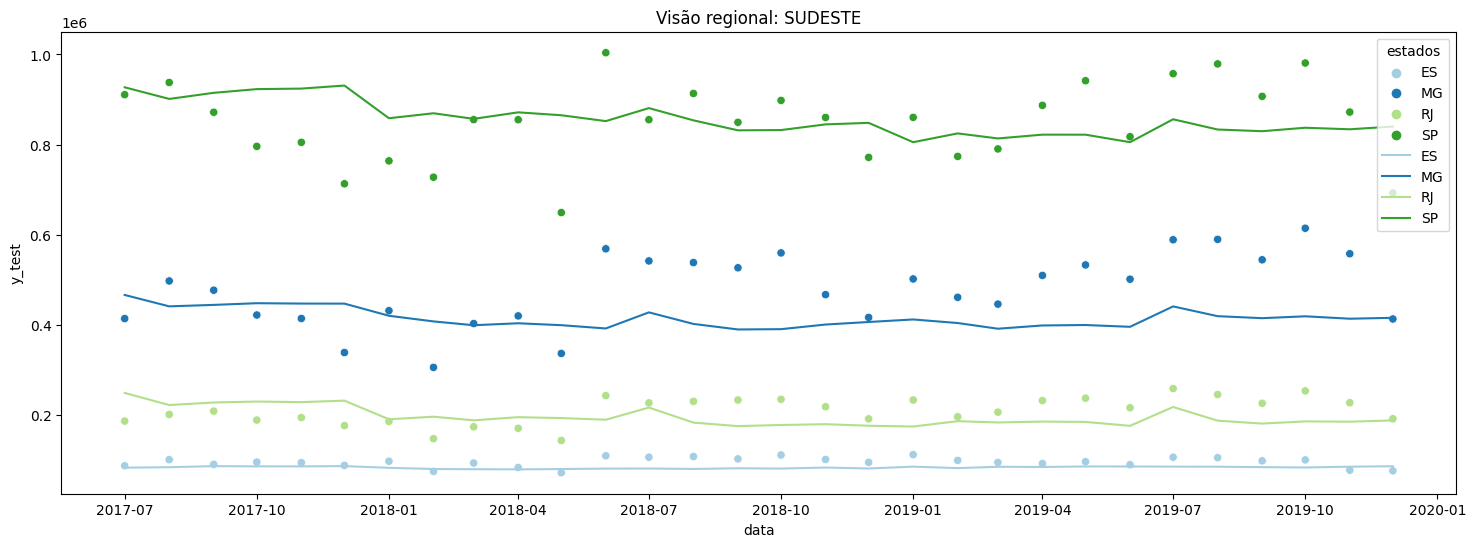

In [67]:
region_graphs(pred, 'SUDESTE')

In [68]:
def show_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
    
    
    plt.title("Visão regional")
    
    for state in reg:
        
        sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
        sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.ylabel="Consumo"
        
    plt.show()

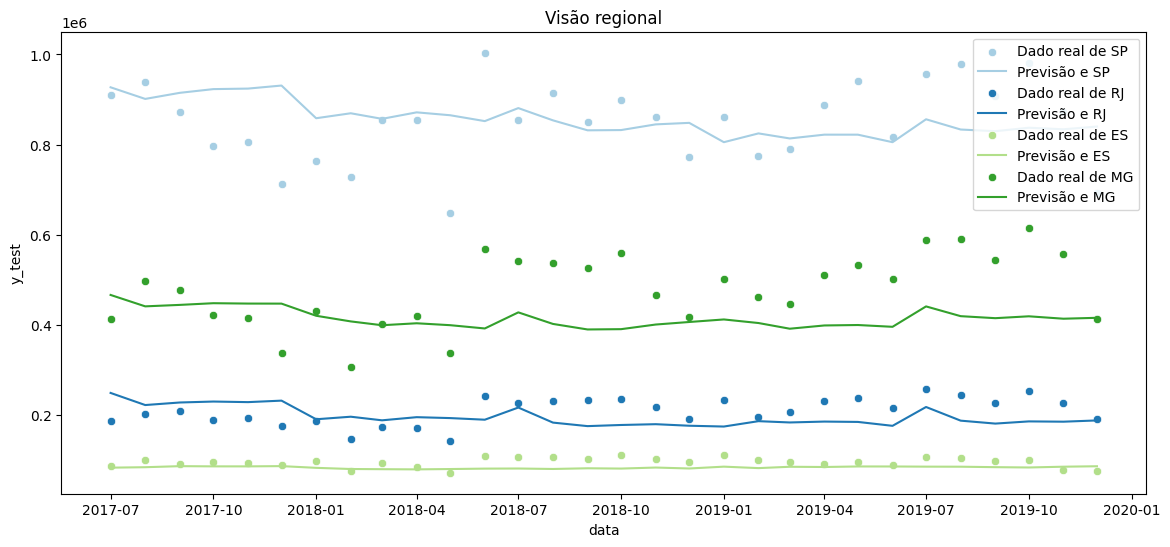

In [69]:
SUDESTE = ['SP', 'RJ', 'ES', 'MG']

show_graphs(pred, SUDESTE)

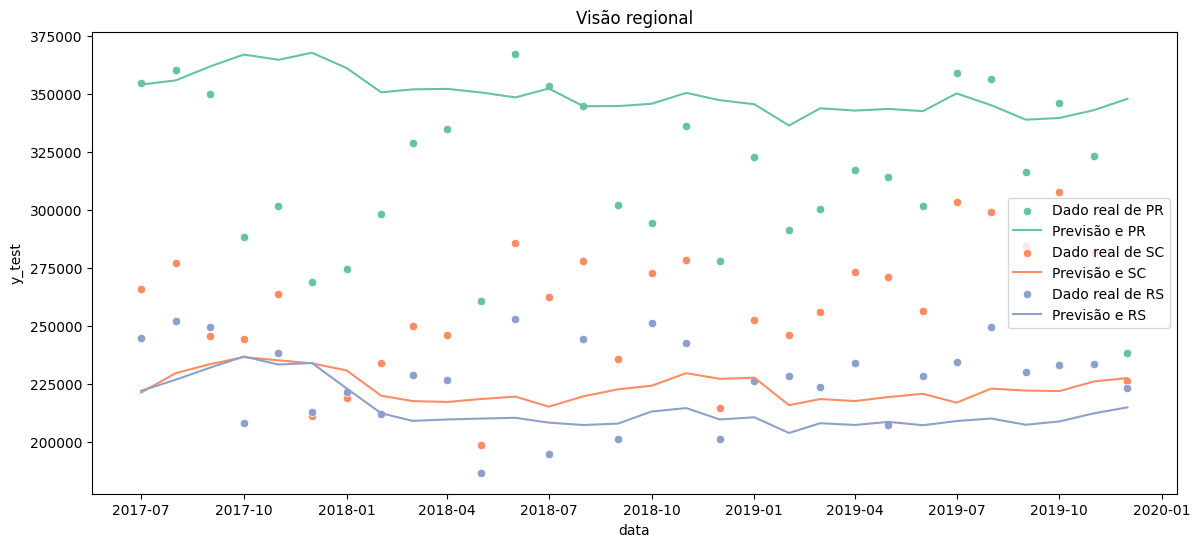

In [70]:
SUL = ['PR', 'SC', 'RS']

sns.set_palette("Set2")

show_graphs(pred, SUL)

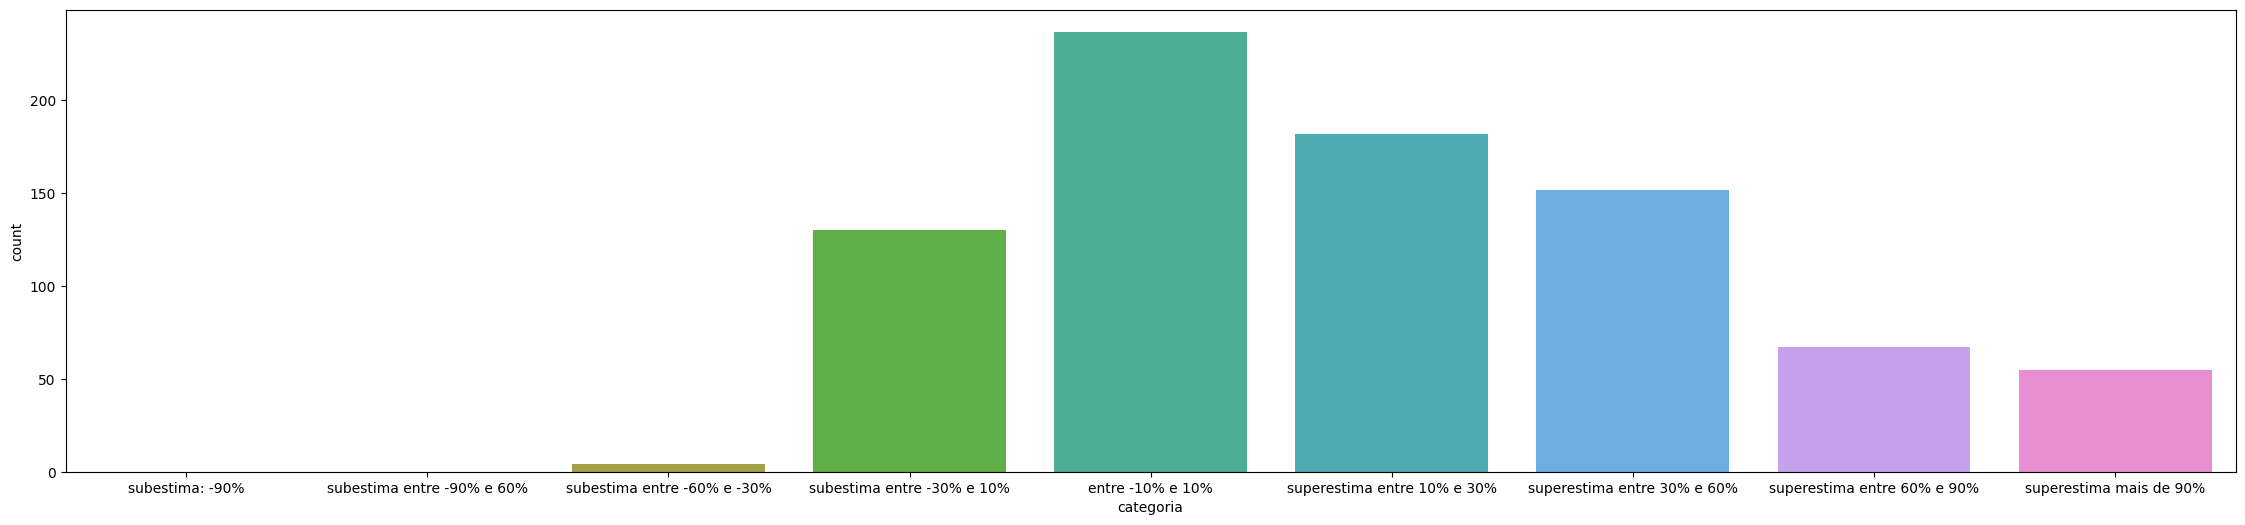

In [71]:
show_delta(np.array(y_test), y_pred.flatten())

In [72]:
#Best: -53222.032266 using {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 3, 'model__n_units': 64}


In [73]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 27517.245882522948
MAE: 15247.293629495818
MAPE: 0.1399183619008636
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 46316.164879025535
MAE: 27429.96617338649
MAPE: 0.30108667170138087


In [74]:
pred = get_pred(y_test, y_pred)

In [75]:
def region_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
        
    plt.title(f"Visão regional: {reg}")
    
    pred=pred[pred['regiao'] == reg]
    
    plt.ylabel="Consumo"
    sns.scatterplot(pred, x=pred.index, y='y_test', hue="estados")
    sns.lineplot(pred, x=pred.index, y='y_pred', hue="estados")
    
#     for state in reg:
        
#         sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
#         sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.show()

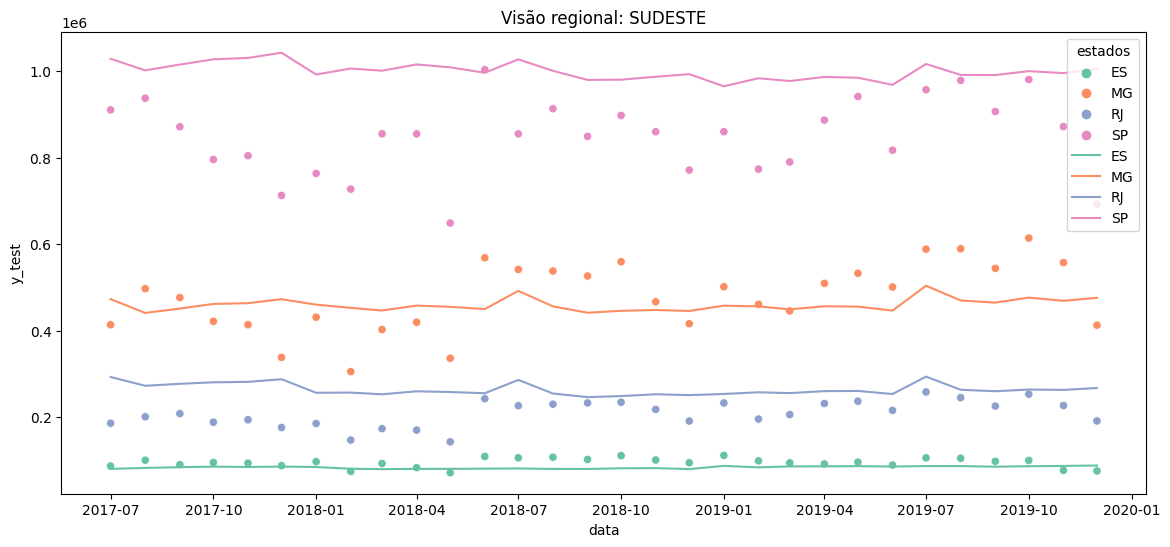

In [76]:
region_graphs(pred, 'SUDESTE')

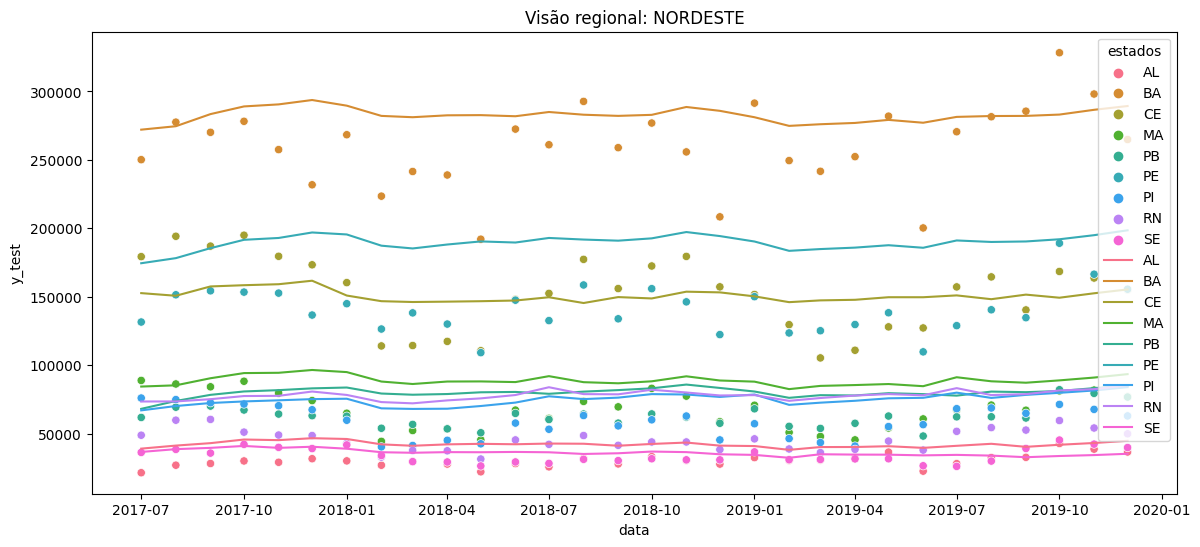

In [77]:
region_graphs(pred, 'NORDESTE')

In [78]:
def region_metrics (pred):

    for reg in pred['regiao'].unique():
        
        print (f"Metricas de {reg}:")
        print (f"RMSE: {mean_squared_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'], squared=False)}")
        print (f"MAPE: {mean_absolute_percentage_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print (f"MAE: {mean_absolute_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print ("-------------------------------\n")

In [79]:
region_metrics(pred)

Metricas de NORTE:
RMSE: 16207.650799422483
MAPE: 0.46471078298665663
MAE: 11097.106766183037
-------------------------------

Metricas de NORDESTE:
RMSE: 28410.13973705106
MAPE: 0.3300117883153599
MAE: 22580.093916377315
-------------------------------

Metricas de CENTRO OESTE:
RMSE: 25858.022647231806
MAPE: 0.21341801993728957
MAE: 19579.746061197915
-------------------------------

Metricas de SUDESTE:
RMSE: 102229.70735883694
MAPE: 0.19319134952879277
MAE: 72072.0234375
-------------------------------

Metricas de SUL:
RMSE: 38576.84200749466
MAPE: 0.12351791378330114
MAE: 31532.813715277778
-------------------------------

